In [1]:
import scipy
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.stats import norm, uniform
from matplotlib import gridspec, rcParams
import matplotlib.pyplot as plt
plt.rc('axes', unicode_minus=False)
rcParams.update({"font.family": 'cmb10',  "font.size": 15,})

from IPython.core.display import display, Latex, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_9297/2952615014.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, Latex, HTML


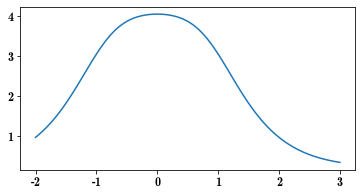

In [9]:
# 1 (a)
rcParams.update({"font.family": 'cmb10',  "font.size": 12})
x = np.linspace(-2, 3, 100)
fig, ax = plt.subplots(figsize = (6, 3))
plt.plot(x, (2*np.cos(x) + 5)/np.sqrt(x**4 + 3))
plt.show()

In [4]:
# 1 (b)
def Gaussian_Quadrature(func, a, b, quadrature):
    if quadrature == 'Legendre':
        X0, W0 = scipy.special.roots_legendre(20)  # nodes, weights
        wfunc = lambda x: 1
    elif quadrature == 'Chebyshev1':
        X0, W0 = scipy.special.roots_chebyt(20)
        wfunc = lambda x: (1-x**2)**-0.5
    elif quadrature == 'Chebyshev2':
        X0, W0 = scipy.special.roots_chebyu(20)
        wfunc = lambda x: (1-x**2)**0.5
    elif quadrature == 'Jacobi':
        alpha, beta = 0.2, 0.2
        X0, W0 = scipy.special.roots_jacobi(20, alpha, beta)
        wfunc = lambda x: pow(1-x, alpha) * pow(1+x, beta)
    else:
        print('Unsupported option ', quadrature)
        return
    x = (b - a) / 2 * X0 + (a + b) / 2
    w = (b - a) / 2 * W0
    ans = sum(w * func(x) / wfunc(X0) )
    return ans

def func(x):
    return (2*np.cos(x) + 5)/np.sqrt(x**4 + 3)

print('True Value:',  integrate.quad(func, -2, 3)[0])
print('\nLegendre:  ',Gaussian_Quadrature(func, -2, 3, 'Legendre'))
print('Chebyshev1:',  Gaussian_Quadrature(func, -2, 3, 'Chebyshev1'))
print('Chebyshev2:',  Gaussian_Quadrature(func, -2, 3, 'Chebyshev2'))
print('Jacobi:    ',  Gaussian_Quadrature(func, -2, 3, 'Jacobi'))

True Value: 11.823574549069427

Legendre:   11.823573601016443
Chebyshev1: 11.826859855303338
Chebyshev2: 11.817596243510268
Jacobi:     11.821452345584136


In [33]:
# 2 (b)
I, J = 100, 2
b0_old, b1_old, sigma_u, sigma_e, sigma_old, Ei  = 1, 1, 1, 1, 1, 1
res = []
X = uniform.rvs(size=(I,J))
Y = 1 + X + norm.rvs(scale=0.5, size=(I,1)) + norm.rvs(scale=0.5, size=(I,J))
for _ in range(100):
    Xi_bar, Yi_bar = np.mean(X, axis=1, keepdims=True), np.mean(Y, axis=1, keepdims=True)
    Ei = sigma_u*(Yi_bar - b0_old - b1_old*Xi_bar) / (sigma_u + sigma_e/J)  # (I, 1)
    
    #b0 = np.mean(Y - b1_old*X - Ei)
    #b1 = np.sum(X*(Y - b0_old - Ei)) / np.sum(X**2)
    b0 = ( np.sum(X*(Y-Ei)) / np.sum(X**2) - np.sum(Y-Ei) / np.sum(X) ) / ( np.sum(X) / np.sum(X**2) - I*J/np.sum(X) )
    b1 = np.sum(X*(Y - b0 - Ei)) / np.sum(X**2)
    sigma_u = sigma_old + np.mean(Ei**2)
    sigma_e = sigma_old + np.mean((Y - b0 - b1*X - Ei)**2)
    
    sigma_old = (sigma_u * sigma_e/J) / (sigma_u + sigma_e/J)
    b0_old, b1_old = b0, b1       
    res.append((b0, b1, np.sqrt(sigma_u), np.sqrt(sigma_e)))
real = [1, 1, 0.5, 0.5]
name = ['$\\beta_0$', '$\\beta_1$', '$\\sigma_u$', '$\\sigma_{\\varepsilon}$']
b0_, b1_, sigma_u_, sigma_e_ = zip(*res)
for i,p in enumerate([b0_, b1_, sigma_u_, sigma_e_]):
    display(Latex('$Mean \quad $%s$ = %.5f \qquad bias=%.5f \qquad Std=%.5f$'%(name[i], np.mean(p), np.mean(p) - real[i],  np.std(p))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### It can be seen, based on observed data,  the  $\beta_0, \beta_1, \sigma_u, \sigma_{\varepsilon}$  fits for real value 1, 1, 0.5, 0.5 after iteration.

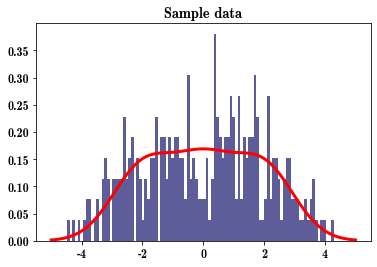

In [5]:
# 3 (c)
data = pd.read_csv('q3.csv')
Y = np.array(data['x'])
plt.hist(Y, bins=100, density=True, color='midnightblue',  alpha=0.7)

x = np.linspace(-5, 5, 100)
y = (norm.pdf(x, loc=-2) + norm.pdf(x, loc=2) + norm.pdf(x, loc=0))/3
plt.plot(x, y, color = 'red',  lw=3)
plt.title('Sample data')
plt.show()

$k$ seems to be 3,$\quad \mu_1, \mu_2, \mu_3$ seem to be \[-2,0,2\]

  mu = [0.17100963540628772, -2.1679496330682113, 2.012429310023475] 


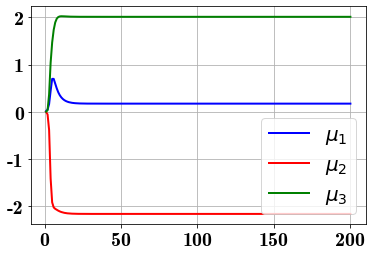

In [6]:
# 3 (d)
rcParams.update({"font.family": 'cmb10',  "font.size": 20,})
k, n, iterations = 3, len(Y), 200
Phi_store, Mu_store = np.zeros((iterations, k)), np.zeros((iterations, k))
phi, mu = [1/3, 1/3, 1/3], [0,0,0]

def P_phi_ui_j(mu, i, j):  # P(ui = j)
    nominaor = phi[j] * norm.pdf(Y[i], loc=mu[j])
    denominator = sum( [phi[j]*norm.pdf(Y[i], loc=mu[j]) for j in range(k)])
    return nominaor/denominator

for h in range(iterations):   
    for j in range(k):
        no = np.sum(P_phi_ui_j(mu, np.arange(n), j) * Y)
        de = np.sum(P_phi_ui_j(mu, np.arange(n), j) )
        mu[j] = no/de
    Mu_store[h] = mu
print('\033[1m', ' mu =', mu, '\033[0m')

x_plot = range(1, iterations+1)
plt.plot(x_plot, Mu_store[:, 0], color = 'blue', lw=2, label = '$\mu_1$')
plt.plot(x_plot, Mu_store[:, 1], color = 'red',  lw=2, label = '$\mu_2$')
plt.plot(x_plot, Mu_store[:, 2], color = 'green',lw=2, label = '$\mu_3$')
plt.legend()
plt.grid()
plt.show()

 phi = [0.32477184 0.34247444 0.33275372]   mu = [-2.18974232  1.9943315   0.1191901 ] 


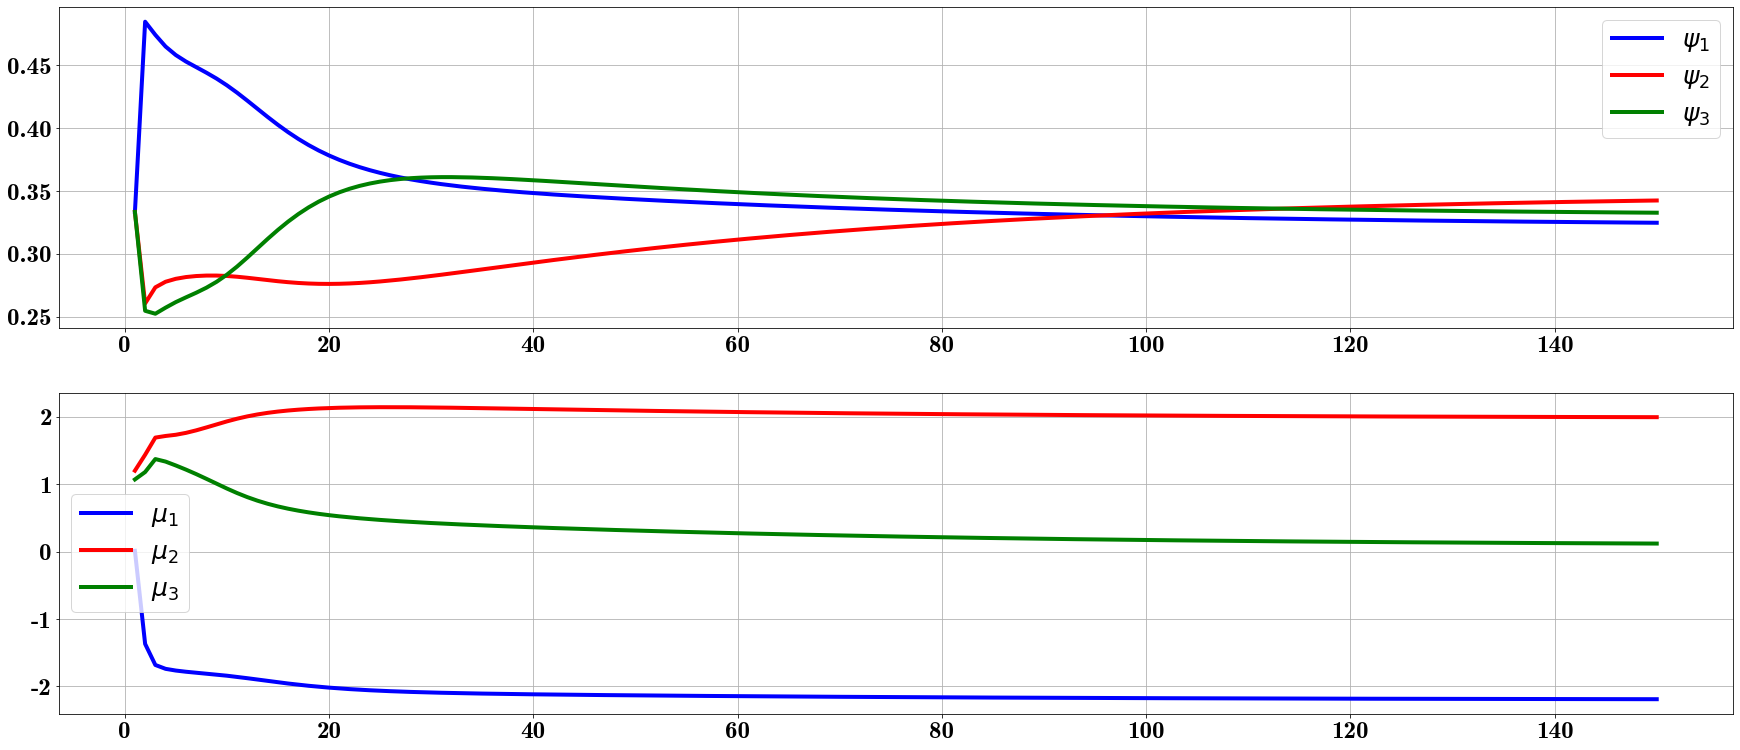

In [7]:
# 3 (e)
rcParams.update({"font.family": 'cmb10',  "font.size": 25})

k, n, iterations = 3, len(Y), 150
Phi_store, Mu_store = np.zeros((iterations, k)), np.zeros((iterations, k))
phi, mu = np.ones(k)/k, np.ones(k)
phi_old, mu_old = phi, mu

def P_ui_j(phi_, mu_, i, j):  # P(ui = j)
    nominaor = phi_[j] * norm.pdf(Y[i], loc=mu_[j])
    denominator = sum( [phi_[j]*norm.pdf(Y[i], loc=mu_[j]) for j in range(k)])
    return nominaor/denominator

for h in range(iterations):   
    for j in range(k):
        phi[j] = np.mean(P_ui_j(phi_old, mu_old, np.arange(n), j))
    for j in range(k):
        no = np.sum(Y * P_ui_j(phi_old, mu_old, np.arange(n), j))
        de = np.sum(P_ui_j(phi_old, mu_old, np.arange(n), j))
        mu[j] = no/de   
    Phi_store[h] = phi_old = phi.copy() 
    Mu_store[h] = mu_old = mu.copy() 
    
print('\033[1m', 'phi =', phi, '  mu =', mu, '\033[0m')

fig, ax = plt.subplots(2, 1, figsize=(30, 13))
gs = gridspec.GridSpec(2, 1, wspace=0.1, hspace=0.2, width_ratios=[1])
x_plot = range(1, iterations+1)
plt.subplot(gs[0,0])
plt.plot(x_plot, Phi_store[:, 0], color = 'blue', lw=4, label = '$\psi_1$')
plt.plot(x_plot, Phi_store[:, 1], color = 'red',  lw=4, label = '$\psi_2$')
plt.plot(x_plot, Phi_store[:, 2], color = 'green',lw=4, label = '$\psi_3$')
plt.legend(prop={'weight':'bold'})
plt.grid()

plt.subplot(gs[1,0])
plt.plot(x_plot, Mu_store[:, 0], color = 'blue', lw=4, label = '$\mu_1$')
plt.plot(x_plot, Mu_store[:, 1], color = 'red',  lw=4, label = '$\mu_2$')
plt.plot(x_plot, Mu_store[:, 2], color = 'green',lw=4, label = '$\mu_3$')
plt.legend()
plt.grid()
plt.show()